In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import math
import xgboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
%matplotlib inline

**Загрузка данных**

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/File/KaggleCSV/train.csv",thousands=' ')
df_test=pd.read_csv("/content/drive/MyDrive/File/KaggleCSV/test.csv",thousands=' ')
df_submission=pd.read_csv("/content/drive/MyDrive/File/KaggleCSV/submission.csv",thousands=' ')
df_X=df_train.iloc[:,:-1]
df_y=df_train.iloc[:,-1]

In [ ]:
df_X.shape

(5282, 19)

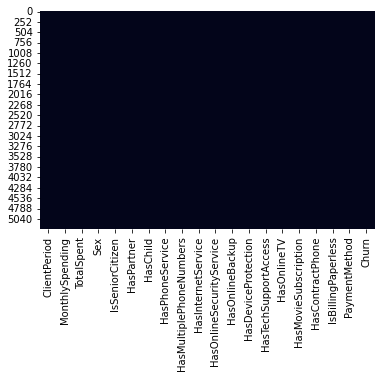

In [ ]:
sns.heatmap(df_train.isnull(),cbar=False) #Построим тепловую карту на наличие NaN в датасете 

In [ ]:
df_train.dtypes #Типы данных

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

**Анализ данных**

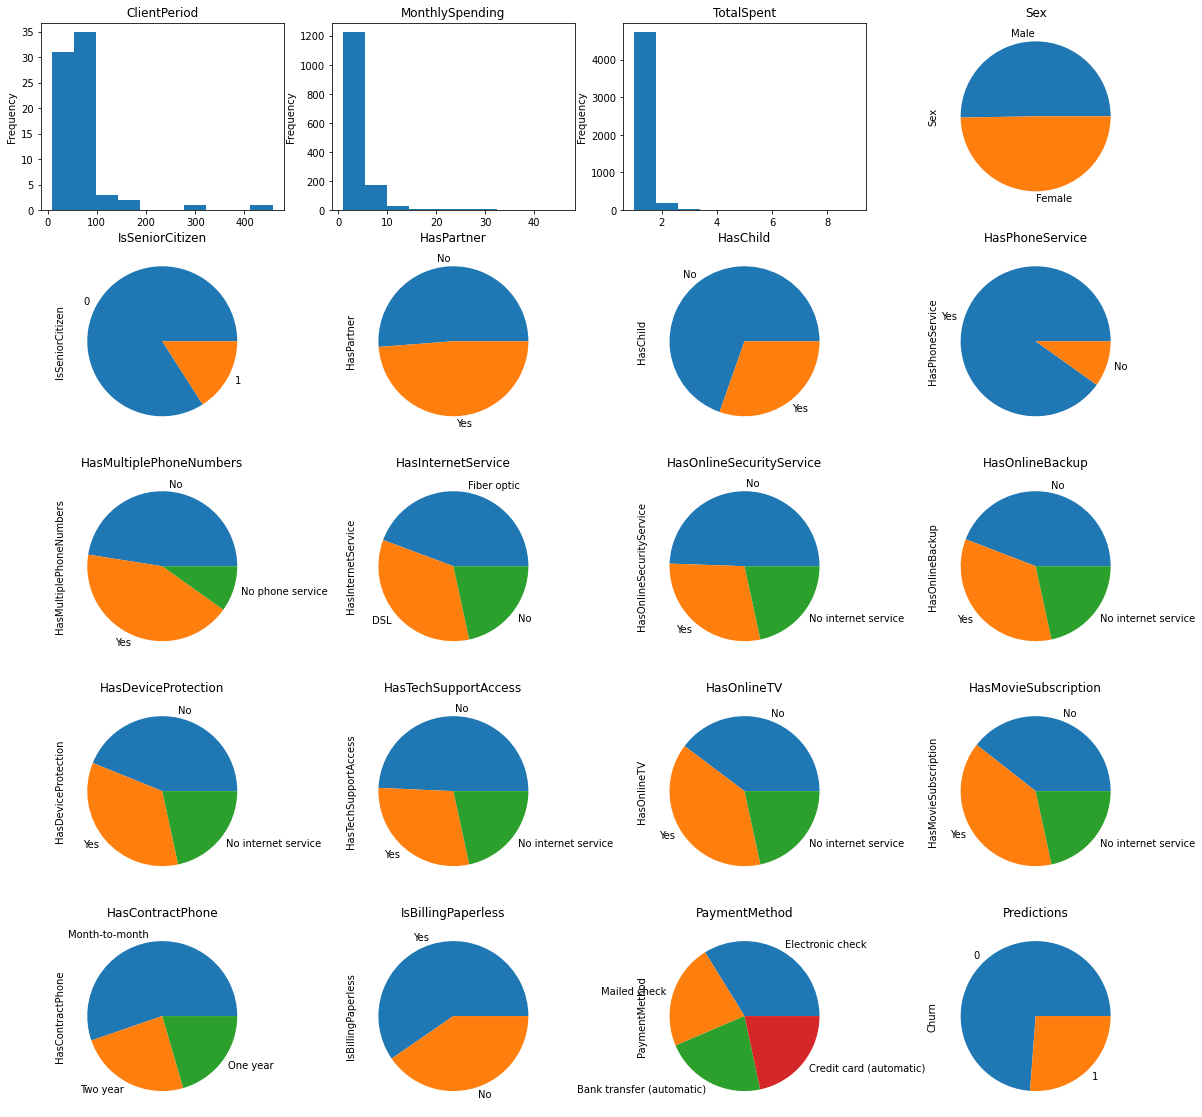

In [ ]:
fig,ax=plt.subplots(nrows=5,ncols=4,figsize=(20,20))#Отрисовка каждого признаков и целелевой переменной

df_X['ClientPeriod'].value_counts().plot(ax=ax[0,0],kind='hist',title='ClientPeriod')
df_X['MonthlySpending'].value_counts().plot(ax=ax[0,1],title='MonthlySpending',kind='hist')
df_X['TotalSpent'].value_counts().plot(ax=ax[0,2],title='TotalSpent',kind='hist')
df_X['Sex'].value_counts().plot(ax=ax[0,3],title='Sex',kind='pie')
df_X['IsSeniorCitizen'].value_counts().plot(ax=ax[1,0],title='IsSeniorCitizen',kind='pie')
df_X['HasPartner'].value_counts().plot(ax=ax[1,1],title='HasPartner',kind='pie')
df_X['HasChild'].value_counts().plot(ax=ax[1,2],title='HasChild',kind='pie')			
df_X['HasPhoneService'].value_counts().plot(ax=ax[1,3],kind='pie',title='HasPhoneService')
df_X['HasMultiplePhoneNumbers'].value_counts().plot(ax=ax[2,0],title='HasMultiplePhoneNumbers',kind='pie')
df_X['HasInternetService'].value_counts().plot(ax=ax[2,1],title='HasInternetService',kind='pie')
df_X['HasOnlineSecurityService'].value_counts().plot(ax=ax[2,2],title='HasOnlineSecurityService',kind='pie')			
df_X['HasOnlineBackup'].value_counts().plot(ax=ax[2,3],title='HasOnlineBackup',kind='pie')
df_X['HasDeviceProtection'].value_counts().plot(ax=ax[3,0],title='HasDeviceProtection',kind='pie')
df_X['HasTechSupportAccess'].value_counts().plot(ax=ax[3,1],title='HasTechSupportAccess',kind='pie')
df_X['HasOnlineTV'].value_counts().plot(ax=ax[3,2],title='HasOnlineTV',kind='pie')			
df_X['HasMovieSubscription'].value_counts().plot(ax=ax[3,3],title='HasMovieSubscription',kind='pie')
df_X['HasContractPhone'].value_counts().plot(ax=ax[4,0],title='HasContractPhone',kind='pie')
df_X['IsBillingPaperless'].value_counts().plot(ax=ax[4,1],title='IsBillingPaperless',kind='pie')
df_X['PaymentMethod'].value_counts().plot(ax=ax[4,2],title='PaymentMethod',kind='pie')
df_y.value_counts().plot(ax=ax[4,3],title='Predictions',kind='pie')

In [ ]:
'''
В датасете наиболее часто встречаемый тип данных- это object, в случае с двумя значениями в столбцах: "yes","no"- все
сводится к простой замене на тип данных int, соответственно: "1","0".
Но в случае с 3 значениями я решил проверить корреляцию каждого из них(1) с вектором выходных значений, и попробовать 
им сопоставить числовые значения. Чтобы итоговый размер файла не был чрезмерно большим я подстваил только один вектор
признак. 
Проанализировав столбцы признаков из пункта 1, я увидел, что у признака: 'HasMultiplePhoneNumbers'- предсказания
 "No phone service" и "No" совподают в соотношениях, поэтому есть смысл обозначить их одной цифрой 0.
В остальных случаях будут использованы значения: "1","0.5" и "0"

1.'HasMultiplePhoneNumbers' 
  'HasOnlineSecurityService'	
  'HasOnlineBackup'	
  'HasDeviceProtection'	
  'HasTechSupportAccess' 
  'HasOnlineTV'	
  'HasMovieSubscription' 
  'HasContractPhone' 

'''

df_train.groupby(['HasMultiplePhoneNumbers']) ['Churn'].value_counts(normalize=True)

HasMultiplePhoneNumbers  Churn
No                       0        0.753086
                         1        0.246914
No phone service         0        0.752399
                         1        0.247601
Yes                      0        0.717778
                         1        0.282222
Name: Churn, dtype: float64

In [ ]:
'''
Переопределим типы данных в столбцах и удалим ненужные 
'''
df_X['Sex']=df_X['Sex'].replace({'Female':0,'Male':1}).astype(int)
df_X['HasPartner']=df_X['HasPartner'].replace({'No':0,'Yes':1}).astype(int)
df_X['HasChild']=df_X['HasChild'].replace({'No':0,'Yes':1}).astype(int)
df_X['HasPhoneService']=df_X['HasPhoneService'].replace({'No':0,'Yes':1}).astype(int)
df_X['IsBillingPaperless']=df_X['IsBillingPaperless'].replace({'No':0,'Yes':1}).astype(int)
df_X['HasMultiplePhoneNumbers']=df_X['HasMultiplePhoneNumbers'].replace({'No':0,'Yes':1,'No phone service':0}).astype(int)
df_X['HasOnlineSecurityService']=df_X['HasOnlineSecurityService'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_X['HasOnlineBackup']=df_X['HasOnlineBackup'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_X['HasDeviceProtection']=df_X['HasDeviceProtection'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_X['HasTechSupportAccess']=df_X['HasTechSupportAccess'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_X['HasOnlineTV']=df_X['HasOnlineTV'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_X['HasMovieSubscription']=df_X['HasMovieSubscription'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_X['HasContractPhone']=df_X['HasContractPhone'].replace({'One year':0.5,'Two year':1,'Month-to-month':0}).astype(int)
df_X['TotalSpent']=pd.to_numeric(df_X['TotalSpent'],errors='coerce')
df_X.drop('HasInternetService',axis=1,inplace=True)
df_X.drop('PaymentMethod',axis=1,inplace=True)

df_test['Sex']=df_test['Sex'].replace({'Female':0,'Male':1}).astype(int)
df_test['HasPartner']=df_test['HasPartner'].replace({'No':0,'Yes':1}).astype(int)
df_test['HasChild']=df_test['HasChild'].replace({'No':0,'Yes':1}).astype(int)
df_test['HasPhoneService']=df_test['HasPhoneService'].replace({'No':0,'Yes':1}).astype(int)
df_test['IsBillingPaperless']=df_test['IsBillingPaperless'].replace({'No':0,'Yes':1}).astype(int)
df_test['HasMultiplePhoneNumbers']=df_test['HasMultiplePhoneNumbers'].replace({'No':0,'Yes':1,'No phone service':0}).astype(int)
df_test['HasOnlineSecurityService']=df_test['HasOnlineSecurityService'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_test['HasOnlineBackup']=df_test['HasOnlineBackup'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_test['HasDeviceProtection']=df_test['HasDeviceProtection'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_test['HasTechSupportAccess']=df_test['HasTechSupportAccess'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_test['HasOnlineTV']=df_test['HasOnlineTV'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_test['HasMovieSubscription']=df_test['HasMovieSubscription'].replace({'No':0.5,'Yes':1,'No internet service':0}).astype(int)
df_test['HasContractPhone']=df_test['HasContractPhone'].replace({'One year':0.5,'Two year':1,'Month-to-month':0}).astype(int)
df_test['TotalSpent']=pd.to_numeric(df_test['TotalSpent'],errors='coerce')
df_test.drop('HasInternetService',axis=1,inplace=True)
df_test.drop('PaymentMethod',axis=1,inplace=True)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=42)

In [ ]:
df_X.head(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
6,27,90.15,2423.4,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic)
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic)
9,72,61.20,4390.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic)


**Градиентный бустинг**

In [ ]:
model_XGB=xgboost.XGBClassifier(learning_rate=0.1,
                                max_depth=5,
                                n_estimators=5000,
                                subsample=0.5,
                                red_alpha=1)

param={
    'learning_rate':[0.001,0.01,0.1],
    'max_depth':[4,6,8],
    'red_alpha':[0.1,0.4,0.8]
}

grid_CV=GridSearchCV(
    estimator=model_XGB,
    param_grid=param,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_CV.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(max_depth=5, n_estimators=5000,
                                     red_alpha=1, subsample=0.5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [4, 6, 8], 'red_alpha': [0.1, 0.4, 0.8]},
             scoring='roc_auc')

In [ ]:
best_param=grid_CV.best_params_
best_score=grid_CV.best_score_
best_model=grid_CV.best_estimator_
print(f'Лучшие параметры:{best_param}\n\nЛучшее значение:{best_score}\n\nЛучшая модель:{best_model}')

Лучшие параметры:{'learning_rate': 0.001, 'max_depth': 4, 'red_alpha': 0.1}

Лучшее значение:0.8439911170715355

Лучшая модель:XGBClassifier(learning_rate=0.001, max_depth=4, n_estimators=5000,
              red_alpha=0.1, subsample=0.5)


In [ ]:
model_XGB=xgboost.XGBClassifier(learning_rate=0.001,
                                max_depth=4,
                                n_estimators=5000,
                                subsample=0.5,
                                red_alpha=0.1)

model_XGB.fit(X_train,y_train)

XGBClassifier(learning_rate=0.001, max_depth=4, n_estimators=5000,
              red_alpha=0.1, subsample=0.5)

In [ ]:
pred=model_XGB.predict(X_test)
print(roc_auc_score(y_test,pred))

0.6842636288914954


In [ ]:
df_submission['Churn'] = best_model.predict_proba(df_test)[:,1]

        Id     Churn
0        0  0.103639
1        1  0.642183
2        2  0.668980
3        3  0.029743
4        4  0.010729
...    ...       ...
1756  1756  0.082549
1757  1757  0.027960
1758  1758  0.801796
1759  1759  0.547981
1760  1760  0.015089

[1761 rows x 2 columns]


In [ ]:
df_submission.to_csv('/content/drive/MyDrive/File/KaggleCSV/submission.csv',index=False , header = 1)